<center>
    <h1>A Real-time Fire Segmentation Method Based on A Deep Learning Approach</h1>
    <h3>Facundo Nicolas Maidana and Riccardo Spolaor</h3>
    <h4>facundo.maidana@studio.unibo.it; riccardo.spolaor@studio.unibo.it</h4>
</center>

---

This notebook presents the flow of an experiment which aims at reproducing the results of the paper [*A Real-time Fire Segmentation Method Based on A Deep Learning Approach*](./docs/A%20Real-time%20Fire%20Segmentation%20Method%20Based%20on%20A%20Deep%20Learning%20Approach.pdf) <a name="cite_paper"></a>[<sup>[1]</sup>](#note_paper).

The paper proposes a novel approach to handle the segmentation of fire in open areas, such as woods or forests that aims at improving the speed in obtaining the results.

The work consists in the development of an improved version of *Deeplabv3+*, which is an encoder-decoder network used for semantic segmentation tasks. Differently from that model, it uses the lightweight *Mobilenetv3* network in the decoding operations to increase the segmentation speed. For the same reason, it also avoids *atrous convolutions* in spite of losing segmemntation accuracy. In order to compensate for this loss the proposed network introduces two additional shallow features to the decoder rich in pattern information of the input images.

For more detailed informations about the used functions, look into the corresponding docstrings inside the python files, inside the `src` folder.

The dataset used in the experiment is available at the following [link](https://ieee-dataport.org/open-access/flame-dataset-aerial-imagery-pile-burn-detection-using-drones-uavs).
In particular, the user should download the images of fires (*9) Images for fire segmentation (Train/Val/Test) Images.zip*) and the related masks (*10) Masks annotation for fire segmentation (Train/Val/Test) Masks.zip*) zip files in the section *"Dataset Files"* and copy them in the folder `./data`.

---
<small>

<a name="note_paper"></a>[1] Menga Li et al. “A Real-time Fire Segmentation Method Based on A Deep Learning Approach”. In: *IFAC-PapersOnLine*. 2022. url: https://www.sciencedirect.com/science/article/pii/S2405896322005055.

</small>


In [34]:
!pip install opencv-python
!pip install scikit-learn
!pip install matplotlib
!pip install torchinfo

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [9]:
# Settings for autoreloading.

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import numpy as np

In [12]:
# Settings for reproducibility.

from src.utils.seed import set_random_seed

SEED = 42
set_random_seed(SEED)

In [15]:
from torch import cuda

# Set the device on which the model operations are performed.
DEVICE = 'cuda' if cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [16]:
BASE_DIR = '.'

# Data Preparation

In [17]:
ORIGINAL_SHAPE = (3840, 2160)
RESIZE_SHAPE = (512, 512)

## Data Extraction
In this section the images and masks data is extracted from the respective zip files and resized from size $3840 \times 2160$ to the input shape of the network $512 \times 512$. Each image is a matrix of the given shape containing *3 channels* (B, G, R) presenting values within the interval $[0, 255]$. On the other hand, a mask is a matrix of the given size, containing values binary values ($0$ or $1$). The matrices representing the images and the masks are defined as: 
* images: $\mathbb{N}_{[0, 255]}^{512 \times 512 \times 3}$.

* masks: $\mathbb{N}_{[0, 1]}^{512 \times 512}$.

In particular, each image represent a frame of a aerial video taken by a drone, representing a fire in an outdoor area. The respective masks segment semantically the fire from the background.

Images and masks are represented as numpy arrays.

In [20]:
import os
from src.data.dataset_handler import load_images_from_zip

images = load_images_from_zip(os.path.join(BASE_DIR, 'data', 'images.zip'),
                              are_masks=False,
                              resize_shape=RESIZE_SHAPE)

100%|██████████| 2003/2003 [03:29<00:00,  9.55it/s]


In [21]:
import os
from src.data.dataset_handler import load_images_from_zip

masks = load_images_from_zip(os.path.join(BASE_DIR, 'data', 'masks.zip'),
                             are_masks=True,
                             resize_shape=RESIZE_SHAPE)

100%|██████████| 2003/2003 [00:35<00:00, 56.66it/s]


In [22]:
# Assert that the number of images corresponds to the number of masks.
assert len(images) == len(masks), \
    'The number of images does not correspond to the number of masks.'

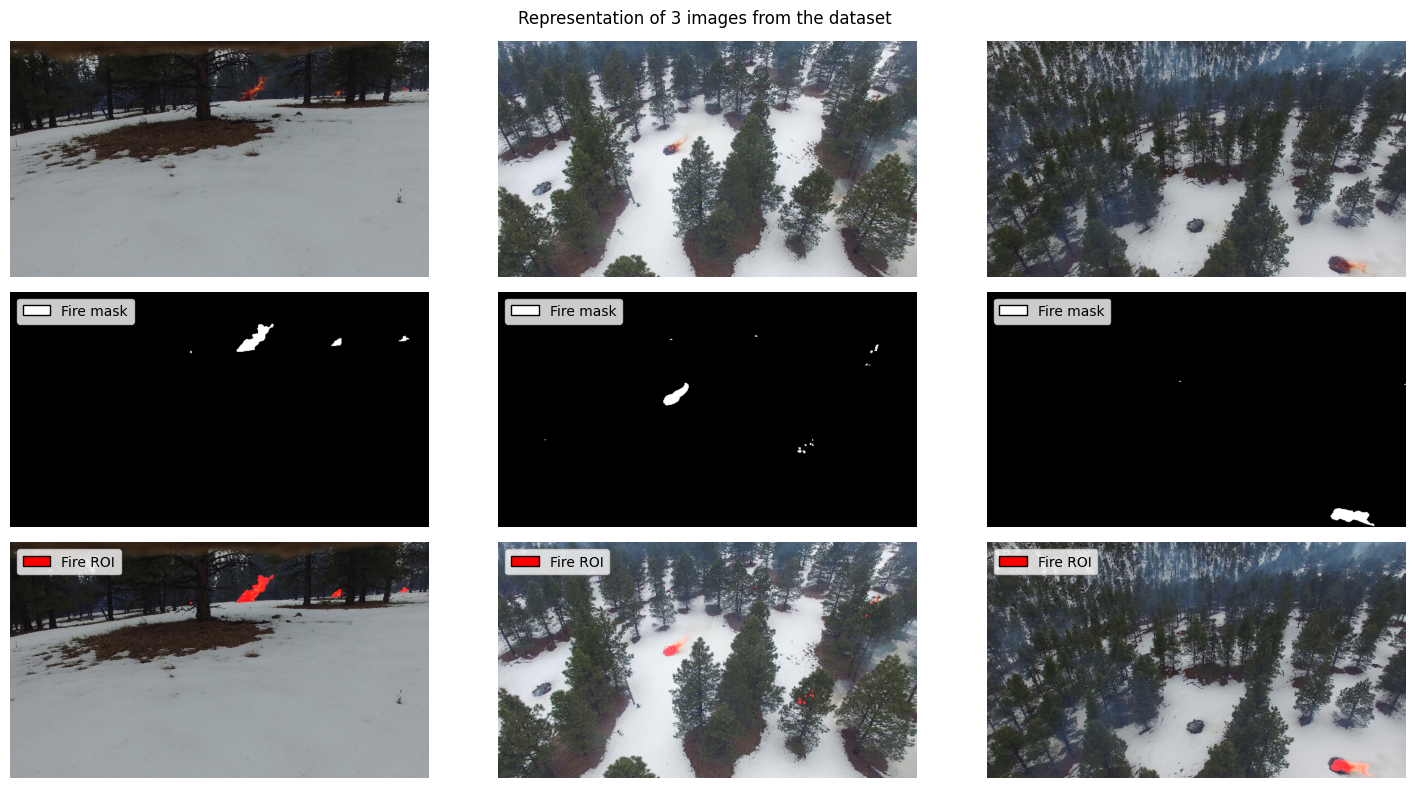

In [25]:
from src.data.analysis import plot_dataset_samples

plot_dataset_samples(images, masks, resize_shape=ORIGINAL_SHAPE)

## Data split

According to the original paper, the dataset is split considering as test data the $15\%$ of the whole dataset.

The rest of the data is used for the training procedure, specifically  $85\%$ of it for training the network and  $15\%$ for validating the results. 

The data is shuffled while splitting according to the original seed, considering each instance indipendent to the other.

In [26]:
from src.data.dataset_handler import get_train_val_test_dataset_split

(X_train, y_train), (X_val, y_val), (X_test, y_test) = \
    get_train_val_test_dataset_split(images, masks, seed=SEED)

In [27]:
print(f'Train shapes: {X_train.shape}, {y_train.shape}')
print(f'Validation shapes: {X_val.shape}, {y_val.shape}')
print(f'Test shapes: {X_test.shape}, {y_test.shape}')

Train shapes: (1446, 512, 512, 3), (1446, 512, 512)
Validation shapes: (256, 512, 512, 3), (256, 512, 512)
Test shapes: (301, 512, 512, 3), (301, 512, 512)


# Model Definition

The network is a modification of the *DeepLabV3+* model which is a model for segmantic segmentation composed of an encoder and a decoder. The encoder extracts features from the input image, and the decoder upsamples the features to the original image size. The applied modification serve to improve the speed of the segmentation process, in order to guarantee its usage for real-time applications. In particular this implementation refears to the semantic segmentation of aerial images captured by drone of woodland fire.

<div align="center">

  ![](https://github.com/maidacundo/real-time-fire-segmentation-deep-learning/blob/main/images/model-diagram.png?raw=1)

</div>

## Encoder

The encoder is composed of the sequence of a *DCNN* backbone and a *ASPP* module.

### DCNN

The *DCNN* backbone is composed of a series of convolutional layers. The first layer is a standard convolutional layer with $16$ convolutional filters. This layer is followed by $15$ *MobileNetV3* bottlenecks. The *MobileNetV3* bottlenecks are divided into different stages according to the size of the input features. In some *MobileNetV3* bottlenecks, the authors also use the *Squeeze-and-Excitation (SE)* module. The *SE* module helps to improve the performance of the model by recalibrating the importance of each feature map.

<div align="center">

  ![](https://github.com/maidacundo/real-time-fire-segmentation-deep-learning/blob/main/images/mobilenetv3-diagram.png?raw=1)

</div>

Two different nonlinear activation functions are used in the
*MobileNetV3* bottleneck: Rectified Linear Unit (*ReLU*) and Hard
versions of Swish (*H-swish*).

The DCNN backbone outputs three intermediate feature maps $f_1$, $f_2$, and $f_3$. They are the results of $1^{st}$, $3^{rd}$ and $6^{th}$ *MobileNetV3* bottleneck layers respectively. 

Moreover, the result of the whole *DCNN* module is fed to the following *ASPP* module.


### ASPP

*Atrous Spatial Pyramid Pooling (ASPP)* is a multi-scale feature aggregation module that is inspired by spatial pyramid pooling (SPP). *ASPP* effectively captures multi-scale contextual information by applying four atrous convolutions with different dilation rates in parallel on the deep feature output generated by the *DCNN*.

*ASPP* is composed of three parts:

- **One $1 \times 1$ standard convolution** is used to generate a general feature map.
- **Three $3 \times 3$ atrous convolutions** with different dilation rates are used to generate three feature maps at different scales. The dilation rates are set to $6$, $12$ and $18$.
- **One Image Pooling** layer to obtain a global feature map.

The four feature maps are then concatenated and fed into a standard $1 \times 1$ convolution to generate the final semantic features $f_4$.

## Decoder

The main purpose of the decoder network is to decode the obtained features by upsampling and convoluting to restore them to the original image size, resulting in the fire segmentation result. The implementation process of the decoder network is as follows:

1. Apply a standard $1 \times 1$ convolution with $256$ convolution kernels to adjust the number of channels of features $f_1$, $f_2$ and $f_3$ to the ones of $f_4$.
2. Upsample features  $f_1$, $f_3$, and $f_4$ to have the same feature size as $f_2$.
3. Concatenate these features and use a $3 \times 3$ convolution to re-adjust the channel number to $2$, namely the background and foreground masks.
4. Upsample the last obtained spatial features to set the final segmentation images to the size of the original image.



In [28]:
from src.model.model import FireSegmentationModel

model = FireSegmentationModel(RESIZE_SHAPE, DEVICE)

In [31]:
import torch 
checkpoint_path = 'model\checkpoints.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=DEVICE)

# Load the model weights into the model
model.load_state_dict(checkpoint['model_state_dict'])
# Make sure to set the model to evaluation mode if you're using it for inference
model.eval()

print("Model loaded successfully!")

<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\c'
C:\Users\migue\AppData\Local\Temp\ipykernel_30332\2572647474.py:2: SyntaxWarning: invalid escape sequence '\c'
  checkpoint_path = 'model\checkpoints.pth'
C:\Users\migue\AppData\Local\Temp\ipykernel_30332\2572647474.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend 

Model loaded successfully!


In [32]:
# Set the batch size used for training.
TRAIN_BATCH_SIZE = 2
# Set the batch size used for evaluation.
EVAL_BATCH_SIZE = 2

In [35]:
from torchinfo import summary

summary(model, input_size=(TRAIN_BATCH_SIZE, 3, *RESIZE_SHAPE))

Layer (type:depth-idx)                                  Output Shape              Param #
FireSegmentationModel                                   [2, 2, 512, 512]          --
├─Encoder: 1-1                                          [2, 16, 256, 256]         --
│    └─DCNN: 2-1                                        [2, 16, 256, 256]         --
│    │    └─Sequential: 3-1                             [2, 16, 256, 256]         464
│    │    └─Sequential: 3-2                             [2, 16, 256, 256]         752
│    │    └─Sequential: 3-3                             [2, 24, 128, 128]         7,880
│    │    └─Sequential: 3-4                             [2, 40, 64, 64]           56,168
│    │    └─Sequential: 3-5                             [2, 160, 32, 32]          2,388,040
│    └─ASPP: 2-2                                        [2, 256, 32, 32]          --
│    │    └─Sequential: 3-6                             [2, 256, 32, 32]          41,472
│    │    └─Sequential: 3-7             

# Training

## Dataset
The train, validation and test dataloaders are obtained from the previously split train, validation and test images and masks.

The train dataloader uses a dataset where data augmentation is applied  to the retrieved images and masks. In particular, the following operations are applied on both images and masks:
* Their perspective can be randomly distorted by a factor up to $0.3$.
* They can be randomly horizontally flipped.
* A *random affine* tranformation can be finally applied to them composed of a rotation in the range $[-45^{\circ}, +45^{\circ}]$, a translation of fraction $0.1$ of the pixels on the horizontal and vertical axis and a scaling between the factors $[0.5, 1.5]$.

A further transformation is applied to just the images of the train dataloader, which consist in a *color jitter* tranformation which can change the brightness of a factor between $-0.2$ and $0.2$ and the hue of $-0.05$ and $0.05$.

The images of both the train, test and validation dataloaders go all through an additional transformation, which consists in the standard scaling of their values applid to each channel separately. The means of each channel $\mu_B$, $\mu_G$ and $\mu_R$ and their standard deviations $\sigma_B$, $\sigma_G$ and $\sigma_R$ are estimated on the train dataset.

The standardization of a channel $C$ of an image $x$ is computed as:
$$x'_C = \frac{x_C - \mu_C}{\sigma_C}$$

In [ ]:
import os
from numpy import save as np_save

train_mean = np.mean(X_train, axis=(-4, -3, -2))
train_std = np.std(X_train, axis=(-4, -3, -2))

train_mean_std_file_path = os.path.join(BASE_DIR, 'model', 'mean-std.npy')
os.makedirs(os.dirname(train_mean_std_file_path), exist_ok=True)
np_save(train_mean_std_file_path, (train_mean, train_std))

In [ ]:
CHANNELS = ['B', 'G', 'R']

print('Mean of the training images per channel:',
      "; ".join([f'{c}: {m:.2f}' for c, m in zip(CHANNELS, train_mean)]))
print('Standard deviation of the training images per channel:',
      "; ".join([f'{c}: {m:.2f}' for c, m in zip(CHANNELS, train_std)]))

Mean of the training images per channel: B: 121.33; G: 119.34; R: 114.98
Standard deviation of the training images per channel: B: 69.79; G: 66.86; R: 65.85


In [ ]:
from src.data.dataloaders import get_dataloader

train_loader = get_dataloader(
    X_train, y_train, train_mean, train_std, batch_size=TRAIN_BATCH_SIZE,
    shuffle=True, apply_augmentation=True)

val_loader = get_dataloader(
    X_val, y_val, train_mean, train_std, batch_size=EVAL_BATCH_SIZE,
    shuffle=False, apply_augmentation=False)

test_loader = get_dataloader(
    X_test, y_test, train_mean, train_std, batch_size=EVAL_BATCH_SIZE,
    shuffle=False, apply_augmentation=False)

## Training Utilities

The training utilities and parameters are assigned.
* `Lion` is used as an optimizer with learning rate $1e-4$ and weight decay $1e-5$.
* Two learning rate schedulers are considered.
    * The first is a `StepLR` scheduler that simply decrements the learning rate of the optimizer of a factor $0.94$ after every epoch.
    * The second is a `ReduceLROnPlateau` scheduler that reduces the learning rate step when a plateau is reached. It reduces the learning rate of $0.98$ if the training *loss* does not decrease of a factor $1e-6$ after $300$ batch steps.
* A checkpoint monitor is initialized to control the performances of the model on the validation set, by saving the best resulting weights which consist in the maximal accuracy computed as the sum of the *Mean Pixel Average (MPA)* and the *Mean Intersection over Union (MIoU)*.
* The number of *epochs* is set to $30$.
* Validation is applied every other $200$ batch steps and at the end of every epoch.

In [ ]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from src.training.lion import Lion

# Set the optimizer.
optimizer = Lion(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Set the Learning Rate Schedulers.
step_lr_scheduler = StepLR(optimizer, gamma=.94, step_size=1)
plateau_lr_scheduler = ReduceLROnPlateau(
    optimizer, factor=.98, patience=300, threshold=1e-6)
lr_schedulers=[step_lr_scheduler, plateau_lr_scheduler]

In [ ]:
import os
from src.training.utils import Checkpoint

# Set the number of epochs.
EPOCHS = 30

# Set the validation step.
VAL_STEP = 200

# Set the checkpoint monitor.
checkpoint = Checkpoint(os.path.join(BASE_DIR, 'model', 'checkpoints.pth'))

## Training Loop
The training procedure is performed. The loss criterion is the *Focal Loss* between the logits of the predictions and the ground truth. This criterion is used in order for the model to focus its training on the harder sematic segmentation to obtain, namely the fire itself.

The *Mean Pixel Average (MPA)* and the *Mean Intersection over Union (MIoU)* are tracked as well on both the train and validation sets.

$$MPA = \frac{1}{k + 1}\sum\limits_{i = 0}^k \frac{p_{ii}}{\sum_{j=0}^k p_{ij}}$$

$$MIoU = \frac{1}{k + 1}\sum\limits_{i = 0}^k \frac{p_{ii}}{\sum_{j=0}^k p_{ij} + \sum_{j=0}^k p_{ji} - p_{ii}} $$

where $k$ represents the number of classes ($k = 1$ , including fire and background), and $p_{ij}$ represents the
number of pixels that belong to class $i$ but are predicted to be
class $j$ ; $p_{ii}$ represents the number of pixels that belong to class
$i$ and are correctly predicted as class $i$.

**⚠ Warning for reproducibility**

Code is not fully reproducible because the upsampling algorithms `upsample_bilinear2d` adopted in the *Decoder* module is not deterministic. This operation may produce nondeterministic gradients when given tensors on a CUDA device.

Different results may be obtained when re-running the pipeline.


In [ ]:
from src.training.training import train

history = train(model, optimizer, train_loader, val_loader, EPOCHS, VAL_STEP,
                DEVICE, checkpoint, lr_schedulers, reload_best_weights=True)

Epoch 1/30
[723/723] - 213s - train: { loss: 0.00218 - MPA: 69.1% - MiOU: 65.9% } - val: { loss: 0.00172 - MPA: 64.4% - MiOU: 63% } - lr: 0.0001
Epoch 2/30
[723/723] - 209s - train: { loss: 0.000685 - MPA: 76.2% - MiOU: 72.3% } - val: { loss: 0.000587 - MPA: 85.8% - MiOU: 78.3% } - lr: 9.4e-05
Epoch 3/30
[723/723] - 211s - train: { loss: 0.000417 - MPA: 82.9% - MiOU: 77.8% } - val: { loss: 0.000461 - MPA: 87.5% - MiOU: 80.7% } - lr: 8.66e-05
Epoch 4/30
[723/723] - 210s - train: { loss: 0.000336 - MPA: 85.9% - MiOU: 80.6% } - val: { loss: 0.000384 - MPA: 89% - MiOU: 83.1% } - lr: 7.82e-05
Epoch 5/30
[723/723] - 216s - train: { loss: 0.000311 - MPA: 86.9% - MiOU: 81.6% } - val: { loss: 0.00039 - MPA: 90.8% - MiOU: 83.3% } - lr: 7.06e-05
Epoch 6/30
[723/723] - 214s - train: { loss: 0.000331 - MPA: 87.1% - MiOU: 81.5% } - val: { loss: 0.000386 - MPA: 90.5% - MiOU: 84% } - lr: 6.37e-05
Epoch 7/30
[723/723] - 214s - train: { loss: 0.000283 - MPA: 87.5% - MiOU: 82.3% } - val: { loss: 0.000347

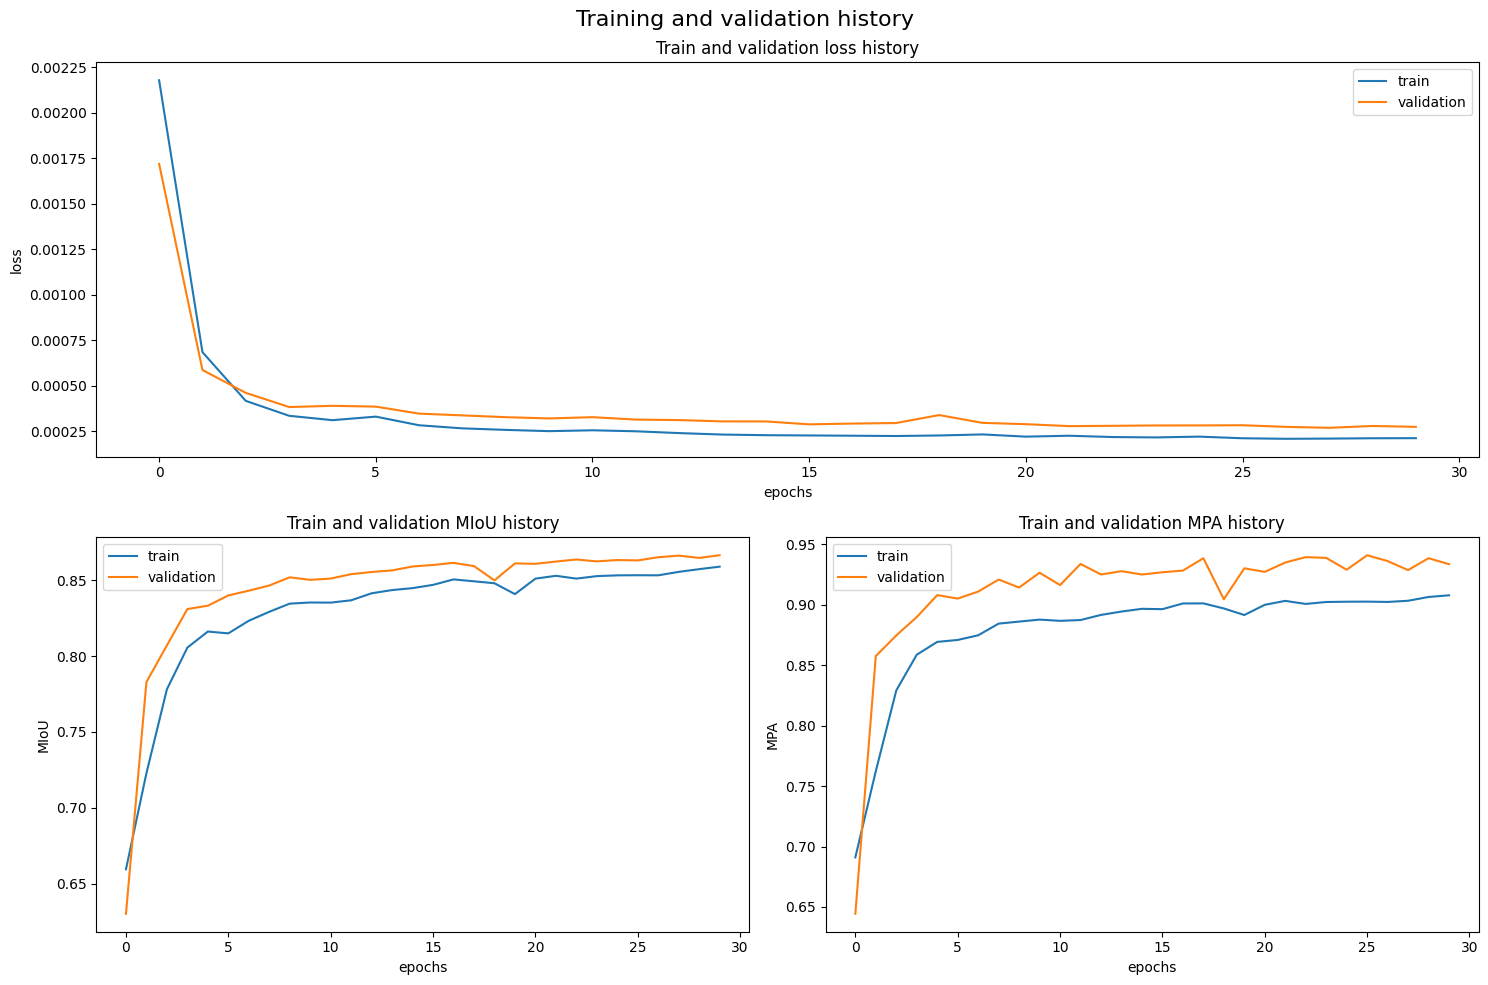

In [ ]:
from src.training.analysis import plot_training_history

plot_training_history(history)

# Results

In this section, the predictions of the model are evaluated and some samples of the outputed segmentation masks are shown.

In [ ]:
checkpoint.load_best_weights(model)
model.eval();

## Validation Results

In the original experiment no results were provided on the validation set, hereby we present ours without any comparison. The metrics used for evaluation are MPA, MIoU and FPS.

In [ ]:
from src.training.training import validate

# Get the validation evaluation results.
val_loss, val_mpa, val_miou, val_fps = validate(
    model, val_loader, DEVICE, resize_evaluation_shape=ORIGINAL_SHAPE)

In [ ]:
print('Validation loss:', f'{val_loss:.3g}')
print('Validation MPA:', f'{val_mpa * 100:.3g}')
print('Validation MIoU:', f'{val_miou * 100:.3g}')
print('Validation FPS:', f'{val_fps:.3g}')

Validation loss: 0.000284
Validation MPA: 94.1
Validation MIoU: 86.3
Validation FPS: 58.9


## Test Results

The results of the model are evaluated on the test set and compared to the outcomes of the original paper. The metrics used for evaluation are once again MPA, MIoU and FPS.

|          | Original Paper | Our results |
| :------- | :------------: | :---------: |
| MPA (%)  | 92.46          |  94.3
| MIoU (%) | 86.98          |  86.1
| FPS      | 59             |  58.5

In [ ]:
from src.training.training import validate

# Get the test evaluation results.
test_loss, test_mpa, test_miou, test_fps = validate(
    model, test_loader, DEVICE, resize_evaluation_shape=ORIGINAL_SHAPE)

In [ ]:
print('Test loss:', f'{test_loss:.3g}')
print('Test MPA:', f'{test_mpa * 100:.3g}')
print('Test MIoU:', f'{test_miou * 100:.3g}')
print('Test FPS:', f'{test_fps:.3g}')

Test loss: 0.000287
Test MPA: 94.3
Test MIoU: 86.1
Test FPS: 58.5


## Qualitative Analysis

In [ ]:
from src.prediction.predict import predict
from src.data.dataset_handler import resize_images

# Get the model test predictions to the original size.
y_pred = predict(model, test_loader, DEVICE)

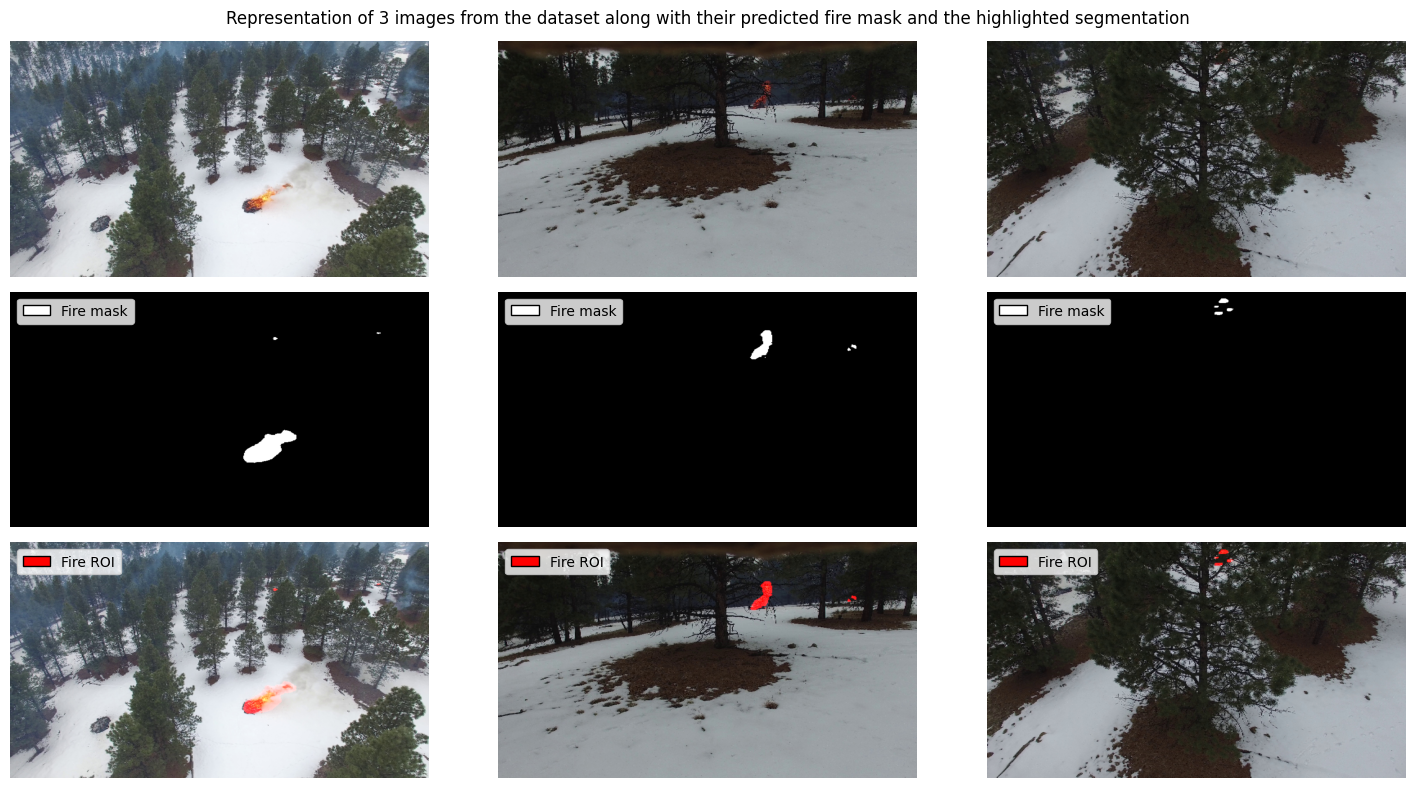

In [ ]:
from src.data.analysis import plot_dataset_samples

plot_dataset_samples(
    X_test, y_pred,
    title='Representation of 3 images from the dataset '
    'along with their predicted fire mask and the highlighted segmentation',
    resize_shape=ORIGINAL_SHAPE)